# Проект "Промышленность"

Чтобы оптимизировать производственные расходы, металлургическая компания решила уменьшить потребление электроэнергии на этапе обработки стали. Мне предстоит построить модель, которая предскажет температуру стали.

## Описание этапа обработки стали

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

##  Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры - `Целевой признак`;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [260]:
# Импортирую библиотеки:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_colwidth', 1000)

from numpy.random import RandomState
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score, cross_validate

# Импортирую модели-регрессоры:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Импортирую метрики:
from sklearn.metrics import mean_absolute_error

# Константа воспроизводимых случайных значений:
RANDOM_STATE = 80822

# Отключу предупреждения:
import warnings
warnings.filterwarnings('ignore')

In [261]:
# Загружаю данные:

try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', sep=',')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', sep=',')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', sep=',')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', sep=',')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', sep=',')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', sep=',')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', sep=',')
    pd.set_option('display.max_columns', None)
except:
    data_arc = pd.read_csv('final_steel/data_arc.csv', sep=',') 
    data_bulk = pd.read_csv('final_steel/data_bulk.csv', sep=',')
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv', sep=',')
    data_gas = pd.read_csv('final_steel/data_gas.csv', sep=',')
    data_temp = pd.read_csv('final_steel/data_temp.csv', sep=',')
    data_wire = pd.read_csv('final_steel/data_wire.csv', sep=',')
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv', sep=',')
    pd.set_option('display.max_columns', None)

## 1. Исследовательский анализ данных

### 1.1. Исследовани данных об электродах

In [262]:
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [263]:
data_arc.sample(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
2850,620,2019-05-26 04:14:57,2019-05-26 04:16:56,0.461558,0.347112
8544,1860,2019-07-08 09:28:39,2019-07-08 09:31:48,0.708460,0.553040
12111,2634,2019-08-10 21:12:33,2019-08-10 21:14:15,0.342987,0.230352
4477,964,2019-06-07 22:06:50,2019-06-07 22:08:21,0.320384,0.229461
1645,353,2019-05-16 16:40:33,2019-05-16 16:42:34,0.506942,0.422235


Названия столбцов стоит изменить на "питовоский" формат, так же есть столбцы, содержаие дату и время.

In [264]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Пропусков нет, но даты хранятся не в формате datetime, это нужно исправить.

In [265]:
# Cмотрю общую статистику:

data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


Видим значительный *разрыв* между 75% квантилем и максимальными значениями. Возможно, в каких-то случаях приходится использовать нестандартно большую можность для нагрева?

Также интересно, что минимальное значение `реактивной мощности` - *отрицательное* (-715.5). Можно ли это считать выбросом? Есть ли еще отрицательные значения? Стоит поисследовать это. 

Нашла, что такое возможно: реактивная мощность может быть как *положительной величиной* (если нагрузка имеет активно-индуктивный характер), так и *отрицательной* (если нагрузка имеет активно-ёмкостный характер). Данное обстоятельство подчёркивает тот факт, что реактивная мощность не участвует в работе электрического тока. Когда устройство имеет *положительную реактивную мощность*, то принято говорить, что оно её *потребляет*, а когда *отрицательную* — то *производит*. 

Звучит странно, наш печь-ковш должен потреблять энергию, а не производить её...

Исследую, сколько циклов (итераций) нагрева обычно бывает за одну партию:

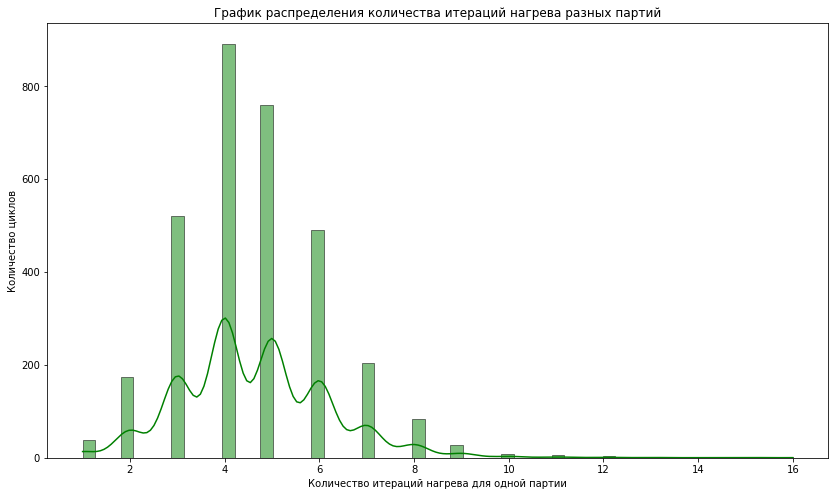

In [266]:
# Строю график распределения количества итераций нагрева разных партий:

fig = plt.figure(figsize=(14, 8))
ax = sns.histplot(data_arc.groupby('key')['Активная мощность'].count(), kde=True, linewidth=0.5, color = 'green')
ax.set(xlabel = 'Количество итераций нагрева для одной партии', ylabel = 'Количество циклов',
       title ='График распределения количества итераций нагрева разных партий')
plt.show()

Видим, что чаще всего бывает 4-5 итераций нагрева для одной партии.

Посмотрю графики распределения мощностей нагрева:

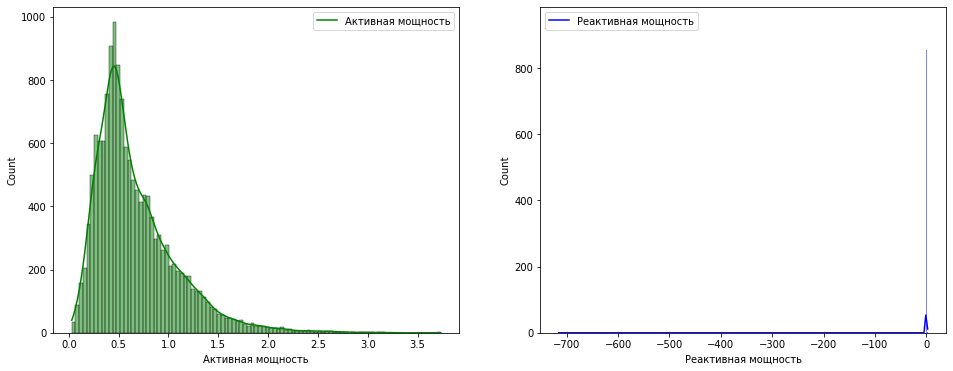

In [267]:
fig = plt.figure(figsize=(16, 6))

ax_1 = fig.add_subplot(1, 2, 1)
ax_1  = sns.histplot(data_arc['Активная мощность'], kde=True, label='Распределение активных мощностей нагрева', color='green')

ax_2 = fig.add_subplot(1, 2, 2)
ax_2  = sns.histplot(data_arc['Реактивная мощность'], kde=True, label='Распределение реактивных мощностей нагрева', color='blue') 

ax_1.legend(['Активная мощность'])
ax_2.legend(['Реактивная мощность'])
plt.show()

На графике реактивной мощности замечен выброс.

Исследую отрицательные значения реактивной мощности:

In [268]:
data_arc.sort_values(by='Реактивная мощность').head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
5596,1216,2019-06-16 08:22:19,2019-06-16 08:22:30,0.030188,0.020806
2419,521,2019-05-22 17:42:57,2019-05-22 17:43:11,0.030563,0.021154
4914,1060,2019-06-11 04:31:57,2019-06-11 04:32:08,0.031630,0.022485
4633,1000,2019-06-09 01:17:44,2019-06-09 01:17:57,0.038186,0.022983
676,146,2019-05-08 19:18:55,2019-05-08 19:19:07,0.035400,0.023228
4063,873,2019-06-04 18:34:19,2019-06-04 18:34:30,0.040905,0.023569
6580,1432,2019-06-23 21:13:19,2019-06-23 21:13:34,0.034053,0.025329
8704,1892,2019-07-09 18:51:37,2019-07-09 18:51:50,0.038364,0.026079
4615,996,2019-06-08 22:06:27,2019-06-08 22:09:03,0.035165,0.026222


Подтвердили теорию, что отрицательное знаечние - это выброс. 

Чтобы заменить это отрицательное значение на что-нибудь другое и адекватное, посмотрим, какие итерации нагрева были в этой партии:

Для замены выброса можно расситать коэффициент зависимоти - отношение active_power к reactive_power в каждом наблюдении в ключе, взять среднюю полученных значений коэффициентов. Среднее значение коэффициента умножить на значение active_power, получим нужное значение reactive_power.

**Вывод по исследованию данных об электродах:**

- Нужно переименовать столбцы под нужный формат(названия столбцов на английском языке, прописными буквами, без пробелов, "верблюжим" типом), данные привести к нужному типу (дата в datetime).
- Заменить отрицательную аномалию в реактивной мощности на адекватное значение.
- Выяснили, что чаще всего бывает 4-5 итераций нагрева для одной партии.

### 1.2. Исследование данных о сыпучих материалах

In [269]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [270]:
data_bulk.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
528,557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,NaN
2713,2814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.0,NaN,206.0,NaN
807,842,NaN,NaN,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,132.0,101.0
139,153,NaN,NaN,NaN,NaN,NaN,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN
2116,2188,NaN,NaN,NaN,95.0,NaN,NaN,NaN,NaN,NaN,52.0,NaN,313.0,NaN,197.0,171.0


In [271]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


In [272]:
data_bulk_time.sample(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1047,1093,NaN,NaN,2019-06-12 08:10:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-12 08:04:39,NaN
150,164,NaN,NaN,2019-05-09 12:02:56,NaN,NaN,2019-05-09 12:02:55,NaN,NaN,NaN,NaN,NaN,2019-05-09 11:38:03,NaN,2019-05-09 11:38:03,2019-05-09 11:38:03
708,741,NaN,NaN,NaN,2019-05-30 20:49:52,NaN,NaN,NaN,NaN,NaN,2019-05-30 20:49:52,NaN,2019-05-30 20:41:23,NaN,2019-05-30 20:41:23,2019-05-30 20:41:23
1966,2035,NaN,NaN,NaN,NaN,NaN,2019-07-21 01:50:04,NaN,NaN,NaN,NaN,NaN,2019-07-21 01:41:07,NaN,2019-07-21 01:41:07,2019-07-21 01:41:07
27,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-04 08:30:00,NaN,2019-05-04 08:30:00,NaN


На первый взгляд, много пропусков. Посмотрим подробней:

In [273]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [274]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Обе таблицы содержат аналогичную структуру данных, описывают одни и те же объекты - сыпучие материалы (Bulk 1 - Bulk15), "пропуски" в данных могут  означать, что какой-то сыпучий материал не использовался в процессе производства той или иной партии.

Исследую, есть ли редкоиспользуемые сыпучие материалы по средним не нулевым значениям:

In [275]:
# Запишу средние не нулевые значения, сортированные по убыванию в отдельную переменную: 

data_bulk_time_ratio = data_bulk_time.drop('key', axis=1).notnull().mean().sort_values(ascending=False)

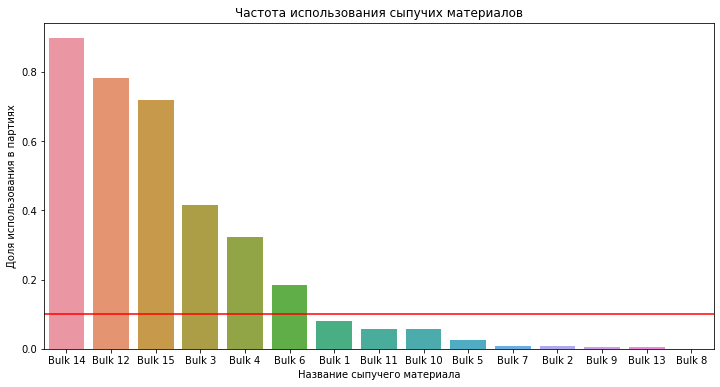

In [276]:
plt.figure(figsize = (12,6))
ax = sns.barplot(x = data_bulk_time_ratio.index, y = data_bulk_time_ratio.values)
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Частота использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Название сыпучего материала')
plt.show()

Теперь видим, что лишь в **менее 10%** партий используются материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8. 
Такие малоиспользуемые сыпучие материалы могут ухудшить качество модели. 
Должен быть рассмотрен вараинт не использовать их для построения модели (не включать в признаки).

**Вывод по исследованию данных о сыпучих материалах:**

- Найдены редкоиспользуемые сыпучие материалы (те, что используются в менее 10% случаях).
- На этапе предобработки предлогаю убрать их, в пользу улучшения качества модели.
- Предлогаю объеденить таблицы data_bulk и data_bulk_time в одну, и привести данные к нужному формату (datetime). Или еще, можно избавиться от части, соедржащей данные о времени в таблице data_bulk_time.


### 1.3. Исследование данных о продувке сплава газом

In [277]:
data_gas.head()

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [278]:
data_gas.sample(5)

,key,Газ 1
1747,1750,18.122748
3020,3023,9.171305
1618,1621,1.944427
2454,2457,2.902352
2460,2463,18.655137


In [279]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Пропусков нет, посмотрим на статистику.

In [280]:
data_gas.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Посмотрим на распределение данных о продувке:

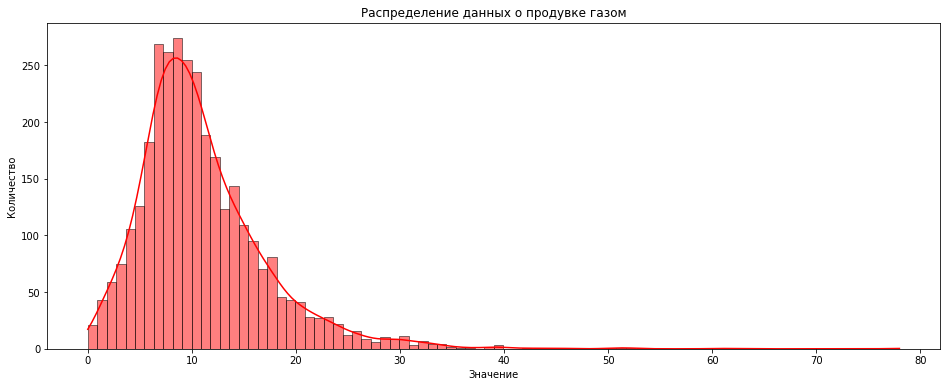

In [281]:
fig = plt.figure(figsize=(16, 6))
ax = sns.histplot(data_gas['Газ 1'], kde=True, linewidth=0.5, color = 'red')
ax.set(xlabel = 'Значение', ylabel = 'Количество',
       title ='Распределение данных о продувке газом')
plt.show()

График похож на нормальное распределение. Ярких выбросов не  видно, есть небольшой "хвост" справа.

**Вывод по исследованию данных о продувке сплава газом**

- Переименовать название столбцов (названия столбцов на английском языке, прописными буквами, без пробелов, "верблюжим" типом).
- Аномалий не выявлено.

### 1.4. Исследование данных измерения температуры (*целевой признак* - последняя температура в каждом ключе)

In [282]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [283]:
data_temp.sample(5)

,key,Время замера,Температура
1077,191,2019-05-10 10:34:05,1578.0
5437,1093,2019-06-12 08:43:36,1579.0
1923,356,2019-05-16 19:32:05,1583.0
3150,621,2019-05-26 04:54:45,1608.0
7627,1545,2019-06-28 03:21:57,1595.0


Нужно переименовать столбцы и привести дату к формату datetime.

In [284]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [285]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


В данных значения температуры (столбец temp) много пропусков (2901). Данные о последнем замере температуры в ключе - целевой признак для построения модели. Нужно внимательно изучить эту проблему и решить, как поступить.

In [286]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


Посмотрим на распределение данных о температуре:

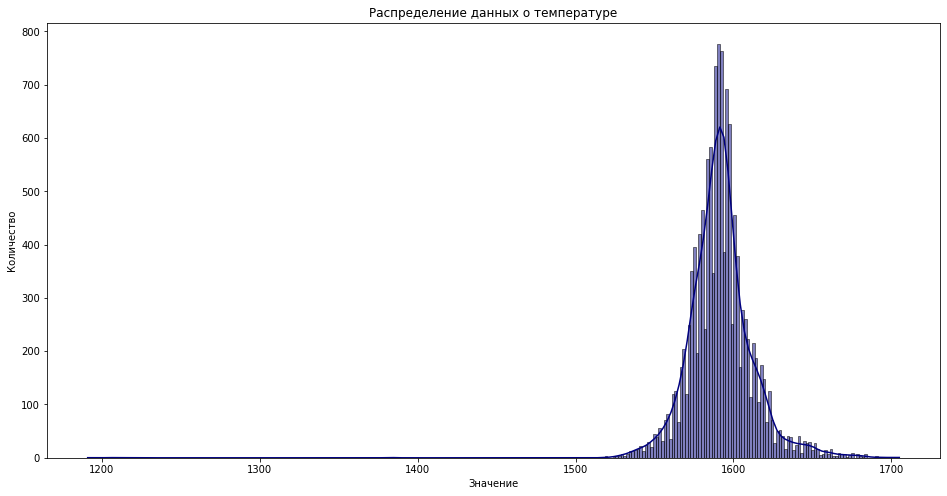

In [287]:
fig = plt.figure(figsize=(16, 8))
ax = sns.histplot(data_temp['Температура'], kde=True, linewidth=0.5, color = 'navy')
ax.set(xlabel = 'Значение', ylabel = 'Количество',
       title ='Распределение данных о температуре')
plt.show()

Заметны низкие значения (менее 1500 градусов), от них тоже можно избавиться на этапе предобработки, но только после формировани я итоговой таблицы по ключам (содержащай в том числе замер начальной температуры и последней). 

**Вывод о исследовании данных измерения температуры**

- Преобразовать столбцы к нужному названию и типу.
- Имеются пропуски в замерах температуры. На этапе предобработки - удалить пропуски, оставить лишь партии, где есть все измерения температуры. В финальную таблицу долны войти данные, где в ключе есть замер начальной температуры и последней.
- После формирования итоговой таблицы по ключам, можно будет отчистить данные и от низких значений температур (менее 1500).

### 1.5. Исследование данных о проволочных материалах

In [288]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [289]:
data_wire.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1131,1199,143.114395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3005,3164,109.243675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2585,2719,95.091362,NaN,NaN,NaN,NaN,72.312248,NaN,NaN,NaN
1524,1603,79.138798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1495,1574,120.182396,20.11672,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [290]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [291]:
data_wire_time.sample(5)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1520,1599,2019-06-29 20:27:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1781,1871,2019-07-08 19:53:39,2019-07-08 20:19:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435,467,2019-05-20 16:29:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2480,2607,2019-08-09 22:33:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,2055,2019-07-21 17:04:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [292]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [293]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [294]:
data_wire.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442842,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


In [295]:
data_wire_time.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Структура данных таблиц data_wire и data_wire_time полностью аналогичны таблицам data_bulk и data_bulk_time.

Исследую, есть ли редкоиспользуемые проволочные материалы по средним не нулевым значениям:

In [296]:
# Запишу средние не нулевые значения проволочных материалов, сортированные по убыванию в отдельную переменную: 

data_wire_time_ratio =  data_wire_time.drop('key', axis=1).notnull().mean().sort_values(ascending=False)

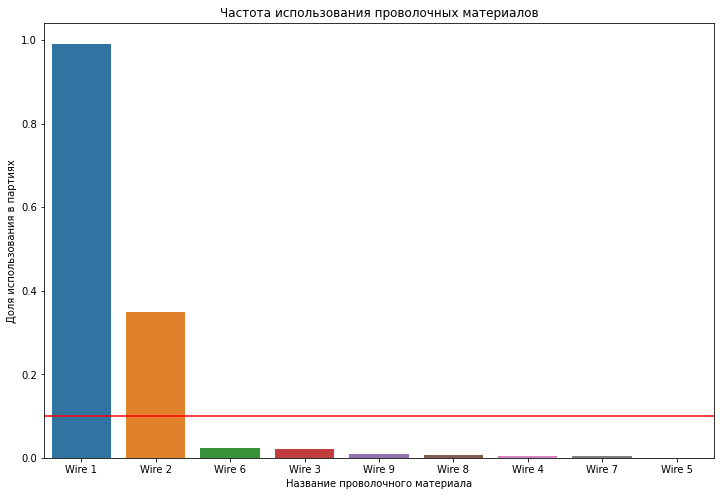

In [297]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = data_wire_time_ratio.index, y = data_wire_time_ratio.values)
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Частота использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Название проволочного материала')
plt.show()

Очень много редкоиспользуемых проволочных материалов. Самые частоиспользуемые - Wire 1 Wire 2.

**Вывод по исследованию данных о проволочных материалах**

- на этапе предобработки потребуется перевести столбцы к нужному виду и типу (дату в datetime). Или еще, можно избавиться от части, соедржащей данные о времени в таблице data_wire_time.
- Избавиться от редкоиспользуемых проволочных материалов, оставив  Wire 1 Wire 2.

## Общий вывод по исследовательскому анализу данных:

- Из таблицы `data_arc` заменить на адекватное значение аномалию в реактивной мощности. Столбцы переименовать (назвать английским языком, прописными буквами, без пробелов, верблюжим типом), данные приведены к нужному типу (дата в datetime). 

- Найдены редкоиспользуемые сыпучие и проволочные материалы (те, что используются в менее 10% случаях).
На этапе предобработки предлогаю убрать их, в пользу улучшения качества будующей модели.
Также предлогаю объеденить таблицы `data_bulk` и `data_bulk_time` в одну, и привести данные к нужному формату (datetime), как и в случае таблиц `data_wire` и `data_wire_time`. Так как они имеют общую структуру хранения данных. Время тут не влияет весомой роли, можно удалить эту часть данных.

- Касаемо таблицы `data_gas`, там не выявлено явных аномалий, столбцы нужно привести к нужному формату и типу.

- Самая важная таблица - `data_temp`, содержащая наш будущий целевой признак - последнее измерение температуры в ключе, таблиц имеет пропуски в данных 2901, на этапе предобработки стоит избавится от них, а также удостовериться в том, что во всех итоговых ключах есть замер начальной температуры и последней, если где-то такие условия не учтены, то удалить такие данные.

  В целом, таблицы требуют предобработки и группировки в единую талицу по одинаковому ключу (`key`).

## 2. Предобработка данных

### 2.1. Предобработка таблицы `data_arc` (данные об электродах)

- Из таблицы `data_arc` нужно заменть на адекватное значение отрицательную аномалию в реактивной мощности (для замены выброса можно расситать коэффициент зависимоти - отношение active_power к reactive_power в каждом наблюдении в ключе, взять среднюю полученных значений коэффициентов и множить на значение active_power, получим нужное значение reactive_power).

- Столбцы переименовать (назвать английским языком, прописными буквами, без пробелов, верблюжим типом), данные привести к нужному типу (дата в datetime):

In [298]:
# Исправляю названия столбцов:
data_arc.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']

In [299]:
# Меняю тип данных столбцов, содержащих дату в datetime:

data_arc['start_arc_heating'] = pd.to_datetime(data_arc['start_arc_heating'])
data_arc['end_arc_heating'] = pd.to_datetime(data_arc['end_arc_heating'])

In [300]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   key                14876 non-null  int64         
 1   start_arc_heating  14876 non-null  datetime64[ns]
 2   end_arc_heating    14876 non-null  datetime64[ns]
 3   active_power       14876 non-null  float64       
 4   reactive_power     14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Смотрю ключ, в котором содержится отрицательный выброс:

In [301]:
anomaly_key = data_arc[data_arc['key'] == 2116]
anomaly_key

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


Рассчитываю средний коэффициент зависимости мощностей в ключе с аномалией:

In [302]:
coef = (anomaly_key['active_power'] / anomaly_key['reactive_power']).mean()
coef

1.1098528948494308

In [303]:
# Произвожу замену отрицательного знаечния:

data_arc.loc[data_arc['reactive_power'] < -715, 'reactive_power'] = coef * data_arc['active_power']

Убеждаюсь, что выброса больше

In [304]:
data_arc[data_arc['key'] == 2116]

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.433266,0.306141
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.620265,0.408352
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,0.550246
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.299368,0.198796


**Вывод:**

В результате предобработки таблицы `data_arc` типы данных и названия столбцов преведены в порядок, заменена аномалия в реактивной мощности.

### 2.2. Предобработка данных о подаче сыпучих материалов (`data_bulk` и `data_bulk_time`)

- Объединить таблицы  `data_bulk` и `data_bulk_time`

- Привести даты к типу datetime 

- Удалить редкоиспольщуемые сыпучие материалы: Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8 

Создам функцию loose_funk по предобработке и объединению таблиц с сыпучими, и, в последующем, с проволочными материалами:

In [305]:
def loose_funk(df, data):
    """
        Input: df, data - таблицы pd.DataFrame.
        Output: Предобработанная объединенная таблица частоиспользуемых материалов.
        Description: Функция предобрабоки дынных о материалах.

    """
    #Соединим датасеты значений и времени материалов:
    dfs_join = df.join(data, how='inner', lsuffix='', rsuffix='_time')

    #Соберем статистику использования материалов:
    data_statistics = data.notnull().mean().sort_values(ascending=False)

    #Возьмем только те материалы, которые используются в более чем 10% партий:
    data_include = data_statistics[data_statistics >= 0.1].index[1:] # убираю поле с ключом (key)

    #Создадим пустой датафрейм для объединения:
    data_combined = pd.DataFrame()

    #Для каждого материала выполним "развертку" и добавим результаты в общую таблицу data_combined:
    for material in data_include:
        data_current = dfs_join[['key', str(material), str(material) + '_time']] \
            .melt(id_vars=['key', str(material) + '_time'], value_vars=[str(material)]).dropna()
        data_current.columns = ['key', 'datetime', 'material', 'value']

        data_combined = pd.concat([data_combined, data_current])

    #приведем дату к формату datetime:
    data_combined['datetime'] = pd.to_datetime(data_combined['datetime'])
    
    #Вернем итоговый датафрейм
    return data_combined

In [306]:
data_bulk_combined = loose_funk(data_bulk, data_bulk_time)
data_bulk_combined 

,key,datetime,material,value
0,1,2019-05-03 11:03:52,Bulk 14,150.0
1,2,2019-05-03 11:40:20,Bulk 14,149.0
2,3,2019-05-03 12:09:40,Bulk 14,152.0
3,4,2019-05-03 12:41:24,Bulk 14,153.0
4,5,2019-05-03 13:12:56,Bulk 14,151.0
...,...,...,...,...
3111,3224,2019-08-31 13:50:34,Bulk 6,36.0
3112,3225,2019-08-31 15:01:05,Bulk 6,162.0
3113,3226,2019-08-31 16:00:49,Bulk 6,96.0
3126,3239,2019-09-01 01:51:58,Bulk 6,114.0


In [307]:
data_bulk_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10392 entries, 0 to 3127
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       10392 non-null  int64         
 1   datetime  10392 non-null  datetime64[ns]
 2   material  10392 non-null  object        
 3   value     10392 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 405.9+ KB


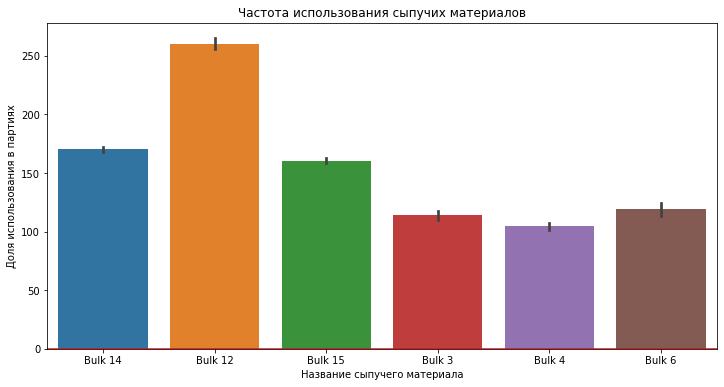

In [308]:
plt.figure(figsize = (12,6))
ax = sns.barplot(x = data_bulk_combined.material, y = data_bulk_combined.value)
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Частота использования сыпучих материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Название сыпучего материала')
plt.show()

**Вывод:**

Отлично, типы данных и названия преведены в порядок, таблицы объединены и в общей таблице (data_bulk_combined) остались только самые частоиспользуемые сыпучие материалы.

### 2.3. Предобработка данных о продувке сплава газом (`data_gas`)


- Переименовать столбцы в соответсвии со стандартом

In [309]:
data_gas.columns = ['key', 'gas']
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [310]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Вывод:**

Отлично названия таблицы преведены в порядок.

**4. Предобработка данных о проволочных материалах (`data_wire` и `data_wire_time`):**

- Объединить таблицы  `data_wire` и `data_wire_time`

- Привести даты к типу datetime 

- Удалить редкоиспольщуемые проволочные материалы, оставив Wire 1 Wire 2.

Воспользуюсь функцией loose_funk:

In [311]:
data_wire_combined = loose_funk(data_wire, data_wire_time)
data_wire_combined

,key,datetime,material,value
0,1,2019-05-03 11:11:41,Wire 1,60.059998
1,2,2019-05-03 11:46:10,Wire 1,96.052315
2,3,2019-05-03 12:13:47,Wire 1,91.160157
3,4,2019-05-03 12:48:05,Wire 1,89.063515
4,5,2019-05-03 13:18:15,Wire 1,89.238236
...,...,...,...,...
3048,3209,2019-08-31 02:34:58,Wire 2,14.145040
3052,3213,2019-08-31 05:24:42,Wire 2,10.073440
3057,3218,2019-08-31 08:16:39,Wire 2,10.073440
3062,3223,2019-08-31 13:14:22,Wire 2,21.202478


In [312]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [313]:
data_wire_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4134 entries, 0 to 3069
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       4134 non-null   int64         
 1   datetime  4134 non-null   datetime64[ns]
 2   material  4134 non-null   object        
 3   value     4134 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 161.5+ KB


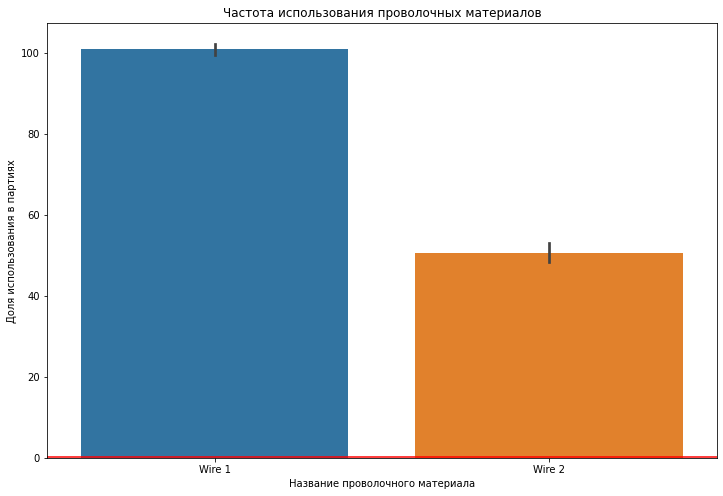

In [314]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = data_wire_combined.material, y = data_wire_combined.value)
ax.axhline(y=0.1, color='r', linestyle='-')
ax.set_title('Частота использования проволочных материалов')
ax.set_ylabel('Доля использования в партиях')
ax.set_xlabel('Название проволочного материала')
plt.show()

**Вывод:**

Отлично, типы данных и названия преведены в порядок, таблицы объединены и в общей таблице (data_wire_combined) остались только самые частоиспользуемые проволочные материалы.

### 2.4. Предобработка данных измерения температуры (`data_temp`):

- Нужно привести дату к правильному формату и названия столбцов

Удалим из таблицы ключи (key), у которых:

- Нет последнего замера температур, когда температуру замеряли до окончания последней итерации нагрева дугой 
- Есть только один замер температуры 

Т.о. в таблице долны остаться данные, где в ключах есть первый и последний замер (когда температуру замеряли до окончания последней итерации нагрева дугой) температуры.

- Удалить низкие температуры (менее 1500 градусов)

In [315]:
data_temp.columns = ['key', 'datetime', 'temp']

In [316]:
data_temp['datetime'] = pd.to_datetime(data_temp['datetime'])

In [317]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       15907 non-null  int64         
 1   datetime  15907 non-null  datetime64[ns]
 2   temp      13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [318]:
data_temp = data_temp.dropna()

In [319]:
data_temp['key'].nunique()

3216

Найду ключи (key), у которых:  нет последнего замера температуры или есть только один замер температуры:

In [320]:
incomplete_keys = [] # пустой список, куда буду добавлять ключи с пропусками

for key in list(data_temp['key'].unique()):  
    if ((data_temp[data_temp['key'] == key]['datetime'].max() < 
        data_arc[data_arc['key'] == key]['end_arc_heating'].max()) or
       (data_temp[data_temp['key'] == key]['datetime'].max() == 
        data_temp[data_temp['key'] == key]['datetime'].min())):
            incomplete_keys.append(key)
        
print(len(incomplete_keys))

872


Неполных ключей 872, посмотрю на них, нет ли ошибки алгоритма:

Оставляю данные, которые удовлетворяют нашему условию по замерам температуры:

In [321]:
full_keys_data = data_temp.loc[~(data_temp['key'].isin(incomplete_keys))]
full_keys_data.shape

(11680, 3)

In [322]:
full_keys_data['key'].nunique()

2344

In [323]:
full_keys_data.isna().sum()

key         0
datetime    0
temp        0
dtype: int64

In [324]:
full_keys_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11680 entries, 0 to 12266
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       11680 non-null  int64         
 1   datetime  11680 non-null  datetime64[ns]
 2   temp      11680 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 365.0 KB


Теперь можно удалить низкие температуры (что менее 1500 градусов):

In [325]:
full_keys_data = full_keys_data.loc[full_keys_data['temp'] > 1500]

In [326]:
full_keys_data.shape

(11674, 3)

Убеждаюсь, что фильтрация сработала:

In [327]:
full_keys_data.loc[full_keys_data['temp'] < 1500, 'temp'].count()

0

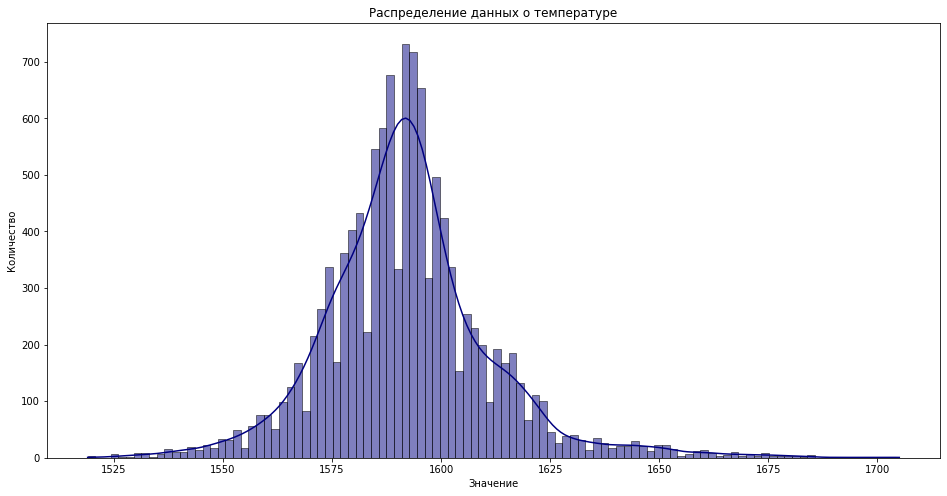

In [328]:
fig = plt.figure(figsize=(16, 8))
ax = sns.histplot(full_keys_data['temp'], kde=True, linewidth=0.5, color = 'navy')
ax.set(xlabel = 'Значение', ylabel = 'Количество',
       title ='Распределение данных о температуре')
plt.show()

Удаляю из таблицы ключи (key), у которых:

- Нет последнего замера температур, когда температуру замеряли до окончания последней итерации нагрева дугой
- Есть только один замер температуры


 Формирую датасет с первым и последним замером температуры

In [329]:
final_t = pd.DataFrame() # Создаю пустой датасет

for key in list(full_keys_data['key'].unique()):
    selection = full_keys_data[full_keys_data['key'] == key]
    min_date = selection['datetime'].min()
    max_date = selection['datetime'].max()
    start_date = selection.loc[selection['datetime'] == max_date]
    end_date = selection.loc[selection['datetime'] == min_date]
    final_row = pd.merge(start_date, end_date, on='key')
    final_t = pd.concat([final_t, final_row], ignore_index=True)
    final_t = final_t[final_t['temp_x'] != final_t['temp_y']]

In [330]:
final_t.shape

(2302, 5)

In [331]:
final_t.head(10)

,key,datetime_x,temp_x,datetime_y,temp_y
0,1,2019-05-03 11:30:39,1613.0,2019-05-03 11:16:18,1571.0
1,2,2019-05-03 11:59:12,1602.0,2019-05-03 11:37:27,1581.0
2,3,2019-05-03 12:34:57,1599.0,2019-05-03 12:13:17,1596.0
3,4,2019-05-03 12:59:25,1625.0,2019-05-03 12:52:57,1601.0
4,5,2019-05-03 13:36:01,1602.0,2019-05-03 13:23:19,1576.0
5,6,2019-05-03 14:12:29,1596.0,2019-05-03 13:49:24,1543.0
6,7,2019-05-03 14:42:37,1599.0,2019-05-03 14:19:43,1586.0
7,8,2019-05-03 15:22:52,1598.0,2019-05-03 15:07:18,1577.0
8,9,2019-05-03 16:01:16,1592.0,2019-05-03 15:37:03,1587.0
9,10,2019-05-03 16:36:08,1593.0,2019-05-03 16:14:29,1574.0


In [332]:
final_t.tail(10)

,key,datetime_x,temp_x,datetime_y,temp_y
2292,2489,2019-08-05 21:02:41,1579.0,2019-08-05 20:30:10,1613.0
2293,2490,2019-08-05 22:27:20,1619.0,2019-08-05 21:55:23,1602.0
2294,2492,2019-08-05 23:19:44,1595.0,2019-08-05 22:41:41,1618.0
2295,2493,2019-08-05 23:59:00,1594.0,2019-08-05 23:37:28,1599.0
2296,2494,2019-08-06 00:23:21,1591.0,2019-08-06 00:12:55,1585.0
2297,2495,2019-08-06 00:54:42,1591.0,2019-08-06 00:35:45,1570.0
2298,2496,2019-08-06 01:29:52,1591.0,2019-08-06 01:02:54,1554.0
2299,2497,2019-08-06 01:53:50,1589.0,2019-08-06 01:41:53,1571.0
2300,2498,2019-08-06 02:25:31,1594.0,2019-08-06 02:03:49,1591.0
2301,2499,2019-08-06 03:00:28,1603.0,2019-08-06 02:40:25,1569.0


Удаляю из датасета столбцы со временем, они не нужны для моделей:

In [333]:
final_t = final_t.drop(['datetime_x', 'datetime_y'], axis=1)
final_t = final_t.rename(columns = {'temp_x': 'end_temp', 'temp_y': 'start_temp'})

In [334]:
final_t.head()

,key,end_temp,start_temp
0,1,1613.0,1571.0
1,2,1602.0,1581.0
2,3,1599.0,1596.0
3,4,1625.0,1601.0
4,5,1602.0,1576.0


**Вывод:**

Типы данных и названия столбцов преведены в порядок. В таблице оставили данные, где в ключах есть первый и последний замер температуры (когда температуру замеряли до окончания последней итерации нагрева дугой).

### 2.5. Создание новых признаков и объединение данных в финальную таблицу

Найду `средние значений активной и реактивной мощности` для каждого ключа:

In [335]:
data_arc_mean_reactive = pd.pivot_table(data_arc,
                             values=['active_power','reactive_power'],
                             index='key',
                             aggfunc={'active_power': np.mean,
                                      'reactive_power': np.mean})


data_arc_mean_reactive.columns = ['mean_active_power','mean_reactive_power']

data_arc_mean_reactive.head(10)

,mean_active_power,mean_reactive_power
key,,
1,0.975629,0.636648
2,0.763150,0.499528
3,0.505176,0.319815
4,0.802313,0.515074
5,0.836793,0.563161
6,0.988777,0.672294
7,0.636844,0.390324
8,0.940689,0.670174
9,0.416390,0.295734


Рассчитаю `длительность нагрева дугой`:

In [336]:
data_arc['arc_heating_time'] = data_arc['end_arc_heating'] - data_arc['start_arc_heating']
data_arc['minutes_arc_heating_time'] = data_arc['arc_heating_time'].dt.total_seconds()/60
data_arc.head(10)

,key,start_arc_heating,end_arc_heating,active_power,reactive_power,arc_heating_time,minutes_arc_heating_time
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,0 days 00:03:48,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0 days 00:03:05,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0 days 00:02:52,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,0 days 00:06:05,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0 days 00:02:28,2.466667
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043,0 days 00:02:17,2.283333
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914,0 days 00:05:38,5.633333
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281,0 days 00:02:06,2.100000
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874,0 days 00:03:30,3.500000
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494,0 days 00:04:40,4.666667


Рассчитываю `общую длительность нагрева дуги`:

In [337]:
duration_heating = data_arc.groupby('key')['minutes_arc_heating_time'].sum()

In [338]:
duration_heating

key
1       18.300000
2       13.516667
3       10.916667
4       12.350000
5       14.483333
          ...    
3237    15.150000
3238     9.100000
3239    20.266667
3240    13.983333
3241    10.983333
Name: minutes_arc_heating_time, Length: 3214, dtype: float64

Рассчитаваю `количество нагревов` для каждого ключа:

In [339]:
count_heating = data_arc.groupby('key')['key'].count().to_frame().rename(columns = {'key': 'count_heating'})

In [340]:
count_heating

,count_heating
key,
1,5
2,4
3,5
4,4
5,4
...,...
3237,5
3238,3
3239,8


Начинаю объединять все таблицы в одну итоговую по единым ключам:

In [341]:
final_t = final_t.merge(duration_heating, how='inner', on='key')
final_t = final_t.merge(count_heating, how='inner', on='key')

In [342]:
final_t.shape

(2302, 5)

In [343]:
final_t = final_t.merge(data_arc_mean_reactive, how='inner', on='key')

In [344]:
final_t.shape

(2302, 7)

In [345]:
final_t.head()

,key,end_temp,start_temp,minutes_arc_heating_time,count_heating,mean_active_power,mean_reactive_power
0,1,1613.0,1571.0,18.300000,5,0.975629,0.636648
1,2,1602.0,1581.0,13.516667,4,0.763150,0.499528
2,3,1599.0,1596.0,10.916667,5,0.505176,0.319815
3,4,1625.0,1601.0,12.350000,4,0.802313,0.515074
4,5,1602.0,1576.0,14.483333,4,0.836793,0.563161


Формирую таблицы со столбцами, где будет информация о количестве каждого испольуемого материала в ключе, для этого ниже использую функцию `get_materials`:

In [346]:
def get_materials(data):
    """
        Input: data - таблицы pd.DataFrame.
        Output: Таблица с количеством используемых материалов в каждом ключе.
        Description: Функция преобразования материалов в отдельные столбцы. Я использую метод pd.get_dummies. 
        Он выносит отдельный материал в отдельный столбец
        и присваивает 1 если матрериал присутствует в наблюдении (ключе) и 0, если нет.
    """
    materials = data['material'].unique()
    material_encode_group = data.groupby(['key', 'material']).sum().reset_index()
    
    dummies = pd.get_dummies(material_encode_group['material'])
    data_material_encode = pd.concat((material_encode_group, dummies), axis=1)
    data_material_encode = data_material_encode.drop('material', axis=1)
    
    for material in materials:
        data_material_encode.loc[data_material_encode[material] == 1, material] = data_material_encode['value']
    
    data_material_final = data_material_encode.groupby('key').sum()
    data_material_final = data_material_final.drop('value', axis=1)    
    
    return data_material_final

In [347]:
# Формирую таблицу с сыпучими материалами:

data_bulk_final = get_materials(data_bulk_combined)

In [348]:
data_bulk_final.head()

,Bulk 12,Bulk 14,Bulk 15,Bulk 3,Bulk 4,Bulk 6
key,,,,,,
1,206.0,150.0,154.0,0.0,43.0,0.0
2,206.0,149.0,154.0,0.0,73.0,0.0
3,205.0,152.0,153.0,0.0,34.0,0.0
4,207.0,153.0,154.0,0.0,81.0,0.0
5,203.0,151.0,152.0,0.0,78.0,0.0


In [349]:
# Формирую таблицу с проволочными материалами:

data_wire_final = get_materials(data_wire_combined)

In [350]:
data_wire_final.head(10)

,Wire 1,Wire 2
key,,
1,60.059998,0.000000
2,96.052315,0.000000
3,91.160157,0.000000
4,89.063515,0.000000
5,89.238236,9.114560
6,99.109917,9.114560
7,98.061600,0.000000
8,155.282394,0.000000
9,113.393279,9.143681


Формирую `итоговую таблицу`, присоединяя таблицы методом `merge` по ключу:

In [351]:
final_t = final_t.merge(data_bulk_final, how='inner', on='key')
final_t.shape

(2227, 13)

In [352]:
final_t = final_t.merge(data_wire_final, how='inner', on='key')
final_t.shape

(2154, 15)

Добавляю данные о продувке газами:

In [353]:
data_gas

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [354]:
final_t = final_t.merge(data_gas, how='inner', on='key')

In [355]:
final_t.shape

(2152, 16)

In [356]:
final_t.isna().sum()

key                         0
end_temp                    0
start_temp                  0
minutes_arc_heating_time    0
count_heating               0
mean_active_power           0
mean_reactive_power         0
Bulk 12                     0
Bulk 14                     0
Bulk 15                     0
Bulk 3                      0
Bulk 4                      0
Bulk 6                      0
Wire 1                      0
Wire 2                      0
gas                         0
dtype: int64

In [357]:
final_t

,key,end_temp,start_temp,minutes_arc_heating_time,count_heating,mean_active_power,mean_reactive_power,Bulk 12,Bulk 14,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Wire 1,Wire 2,gas
0,1,1613.0,1571.0,18.300000,5,0.975629,0.636648,206.0,150.0,154.0,0.0,43.0,0.0,60.059998,0.00000,29.749986
1,2,1602.0,1581.0,13.516667,4,0.763150,0.499528,206.0,149.0,154.0,0.0,73.0,0.0,96.052315,0.00000,12.555561
2,3,1599.0,1596.0,10.916667,5,0.505176,0.319815,205.0,152.0,153.0,0.0,34.0,0.0,91.160157,0.00000,28.554793
3,4,1625.0,1601.0,12.350000,4,0.802313,0.515074,207.0,153.0,154.0,0.0,81.0,0.0,89.063515,0.00000,18.841219
4,5,1602.0,1576.0,14.483333,4,0.836793,0.563161,203.0,151.0,152.0,0.0,78.0,0.0,89.238236,9.11456,5.413692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,2495,1591.0,1570.0,12.050000,4,0.802673,0.590194,256.0,129.0,223.0,21.0,0.0,0.0,89.150879,0.00000,7.125735
2148,2496,1591.0,1554.0,15.666667,6,0.700511,0.468364,256.0,129.0,226.0,0.0,63.0,0.0,114.179527,0.00000,9.412616
2149,2497,1589.0,1571.0,9.483333,3,0.737460,0.617090,230.0,124.0,226.0,0.0,85.0,0.0,94.086723,9.04800,6.271699
2150,2498,1594.0,1591.0,12.500000,5,0.681745,0.471086,206.0,129.0,207.0,90.0,0.0,0.0,118.110717,0.00000,14.953657


### 2.6. Проверка признаков на мультиколлинеарность

In [358]:
# оценим на мультиколлинеарность факторов
# две переменные коллинеарны, когда они находятся между собой в линейной зависимости, если коэффициент корреляции более 0,7
# Корреляция Пирсона измеряет лишь линейные связи, это важно лишь для линейных моделей:

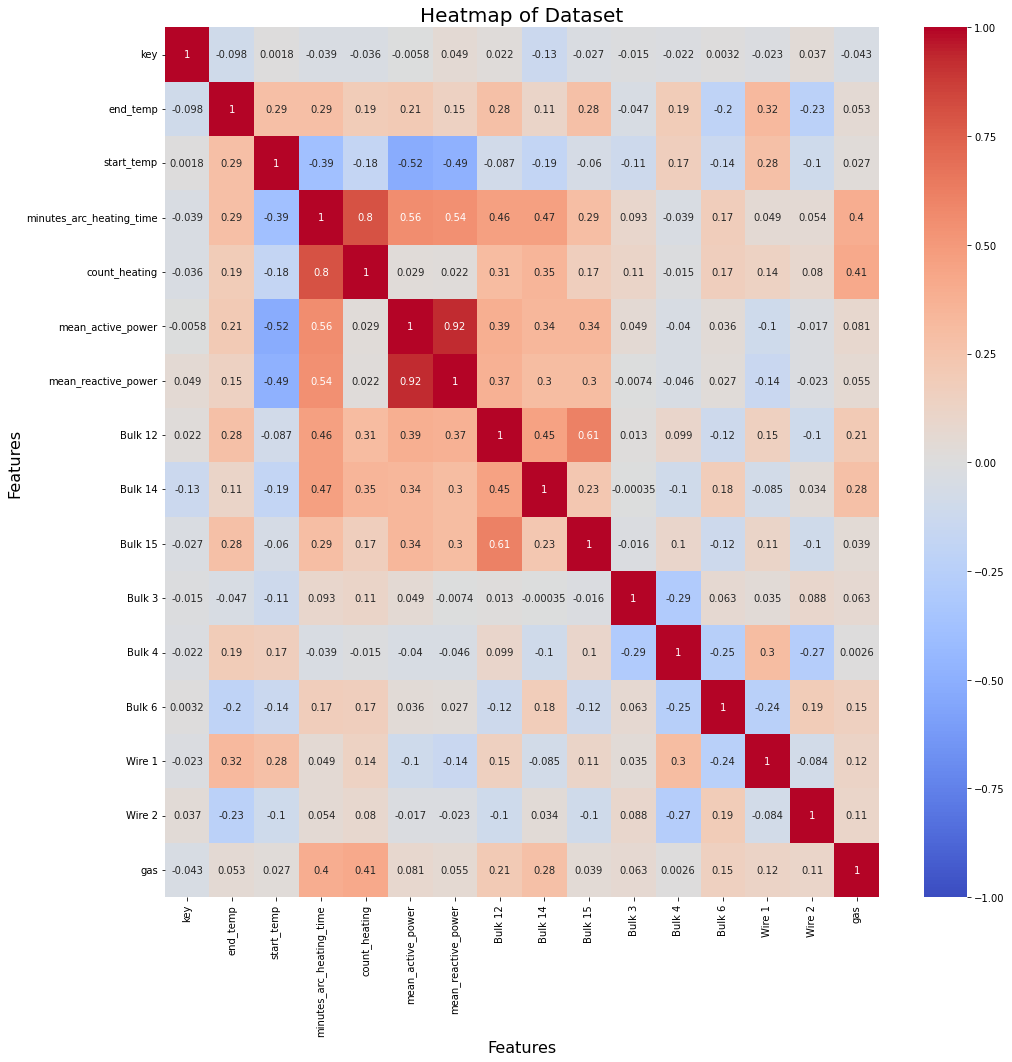

In [359]:
# Посмортрим коэффициенты корреляции итогового фрейма:
corr = final_t.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr, annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.title('Heatmap of Dataset', fontsize=20)
plt.xlabel('Features', fontsize = 16)
plt.ylabel('Features', fontsize = 16);

Выявлены высококоллинеарные признаки `minutes_arc_heating_time` и `count_heating` (коэффициент коллинеарности 0.8), оно и логично.  Предлогаю создать отедльный датасет для линейной регресии и удалить столбец `count_heating`, т.к. корреляция Пирсона измеряет лишь линейные связи, это важно лишь для линейных моделей.

In [360]:
# Удаляю столбец count_heating и создаю отдельный датасет для линейной регрессии:

final_linreg = final_t.drop(['key', 'count_heating'], axis=1)
final_linreg.shape

(2152, 14)

In [361]:
# Для остальных моделей оставляю полный датасет, исключаю лишь столбец key:

final = final_t.drop(['key'], axis=1)

In [362]:
final.corr()['end_temp'] 

end_temp                    1.000000
start_temp                  0.286935
minutes_arc_heating_time    0.287041
count_heating               0.190571
mean_active_power           0.205944
mean_reactive_power         0.146704
Bulk 12                     0.277201
Bulk 14                     0.111808
Bulk 15                     0.275526
Bulk 3                     -0.046611
Bulk 4                      0.192523
Bulk 6                     -0.203898
Wire 1                      0.324016
Wire 2                     -0.230180
gas                         0.053025
Name: end_temp, dtype: float64

In [363]:
final.shape

(2152, 15)

In [364]:
final.columns

Index(['end_temp', 'start_temp', 'minutes_arc_heating_time', 'count_heating',
       'mean_active_power', 'mean_reactive_power', 'Bulk 12', 'Bulk 14',
       'Bulk 15', 'Bulk 3', 'Bulk 4', 'Bulk 6', 'Wire 1', 'Wire 2', 'gas'],
      dtype='object')

**Вывод по Предобработке данных**

- Данные предобработаны, созданы новые признаки, сформирован финальный датасет.

- Выявлены высококоллинеарные признаки `minutes_arc_heating_time` и `count_heating` (коэффициент коллинеарности 0.8), оно и логично. 

- Удален столбец `count_heating`.

- Таким образом, данные подготовлены для обучения к модели. Целевым признаком является столбец end_temp. Остальные столбцы будут использованы для предсказания.

In [365]:
final.head(3)

,end_temp,start_temp,minutes_arc_heating_time,count_heating,mean_active_power,mean_reactive_power,Bulk 12,Bulk 14,Bulk 15,Bulk 3,Bulk 4,Bulk 6,Wire 1,Wire 2,gas
0,1613.0,1571.0,18.300000,5,0.975629,0.636648,206.0,150.0,154.0,0.0,43.0,0.0,60.059998,0.0,29.749986
1,1602.0,1581.0,13.516667,4,0.763150,0.499528,206.0,149.0,154.0,0.0,73.0,0.0,96.052315,0.0,12.555561
2,1599.0,1596.0,10.916667,5,0.505176,0.319815,205.0,152.0,153.0,0.0,34.0,0.0,91.160157,0.0,28.554793


## 3. Обучение разных моделей и оценка их качества с помощью кросс-валидации. Выбор лучшей модели и проверка её на тестовой выборке. Проверка модели на адекватность. 

### 3.1. Подготовка данных к обучению:

#### Разобью данные на `train` и `test` к соотношению 75:25. Выберем количество кросс-валидаций равным 5:

In [366]:
features = final.drop('end_temp', axis=1)
features_linreg = final_linreg.drop('end_temp', axis=1)
target = final['end_temp']
 


features_train, features_test, features_train_linreg, features_test_linreg, target_train, target_test = train_test_split(
                                                            features,
                                                            features_linreg,
                                                            target, 
                                                            test_size=0.25, 
                                                            random_state=RANDOM_STATE)
cv_counts = 5

Проверю размеры выборок:

In [367]:
print('Размер тренериующей выборки:', features_train.shape, target_train.shape)
print('Размер тестовой выборки:', features_test.shape, target_test.shape)
print('Размер тренериующей выборки датасета для линейной регрессии:', features_train_linreg.shape, target_train.shape)
print('Размер тестовой выборки датасета для линейной регрессии:',  features_test_linreg.shape, target_test.shape)

Размер тренериующей выборки: (1614, 14) (1614,)
Размер тестовой выборки: (538, 14) (538,)
Размер тренериующей выборки датасета для линейной регрессии: (1614, 13) (1614,)
Размер тестовой выборки датасета для линейной регрессии: (538, 13) (538,)


### 3.2. Обучение и кросс-валидация моделей на тренировочной выборке, выбор лучшей модели

#### LinearRegression

In [368]:
lr_model = LinearRegression(fit_intercept=True, normalize=True)

In [369]:
print('# Train for mean_absolute_error')
print()
cv_MAE_LR = (cross_val_score(lr_model, 
                             features_train_linreg, 
                             target_train, 
                             cv=cv_counts, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print(f"Mean MAE from CV of LinearRegression: {cv_MAE_LR}")

# Train for mean_absolute_error

Mean MAE from CV of LinearRegression: 6.138953963982029


#### RandomForestRegressor

In [370]:
random_forest_model = RandomForestRegressor(random_state=RANDOM_STATE)

In [371]:
params = {'max_depth':range(2,10),
          'n_estimators': range(20,60),
         }

best_forest = RandomizedSearchCV(random_forest_model,
                                 param_distributions = params,
                                 scoring = 'neg_mean_absolute_error',
                                 random_state=RANDOM_STATE,
                                 cv=cv_counts
                                )

best_forest.fit(features_train, target_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=8

In [372]:
cv_MAE_RF = np.negative(best_forest.best_score_)

print(f"Лучшие гиперпараметры для RandomForestRegressor:", best_forest.best_params_)
print(f"Mean MAE from CV of RandomForestRegressor:", cv_MAE_RF)

Лучшие гиперпараметры для RandomForestRegressor: {'n_estimators': 51, 'max_depth': 9}
Mean MAE from CV of RandomForestRegressor: 6.180365948724428


In [373]:
# print('# Train for mean_absolute_error')
# print()
# cv_MAE_RF = (cross_val_score(random_forest_model, 
#                              features_train, 
#                              target_train, 
#                              cv=cv_counts, 
#                              scoring='neg_mean_absolute_error').mean() * -1)
# print(f"Mean MAE from CV of RandomForestRegressor: {cv_MAE_RF}")

#### Градиентный бустинг CatBoostRegressor

In [374]:
cat_boost_model = CatBoostRegressor(loss_function='MAE', 
                                    eval_metric='MAE',
                                    verbose=False, 
                                    random_seed=RANDOM_STATE)

In [375]:
params={'learning_rate': [0.05, 0.08, 0.09, 0.1],
        'iterations': range(10, 150, 10)
       }

best_cat = RandomizedSearchCV(cat_boost_model,
                                 param_distributions = params,
                                 scoring = 'neg_mean_absolute_error',
                                 random_state=RANDOM_STATE,
                                 cv=cv_counts
                                )

best_cat.fit(features_train, target_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x00000187C232DA48>,
                   iid='warn', n_iter=10, n_jobs=None,
                   param_distributions={'iterations': range(10, 150, 10),
                                        'learning_rate': [0.05, 0.08, 0.09,
                                                          0.1]},
                   pre_dispatch='2*n_jobs', random_state=80822, refit=True,
                   return_train_score=False, scoring='neg_mean_absolute_error',
                   verbose=0)

In [376]:
cv_MAE_Cat = np.negative(best_cat.best_score_)

print(f"Лучшие гиперпараметры для CatBoostRegressor:", best_cat.best_params_)
print(f"Mean MAE from CV of CatBoostRegressor:", cv_MAE_Cat)

Лучшие гиперпараметры для CatBoostRegressor: {'learning_rate': 0.08, 'iterations': 120}
Mean MAE from CV of CatBoostRegressor: 6.013932616842607


In [377]:
# print('# Train for mean_absolute_error')
# print()
# cv_MAE_Cat = (cross_val_score(cat_boost_model, 
#                              features_train, 
#                              target_train, 
#                              cv=cv_counts, 
#                              scoring='neg_mean_absolute_error').mean() * -1)
# print(f"Mean MAE from CV of CatBoostRegressor: {cv_MAE_Cat}")

#### LGBMRegressor

In [378]:
lbgm_model = LGBMRegressor(random_state=RANDOM_STATE) 

In [379]:
params={'learning_rate': [0.04, 0.07, 0.09, 0.1],
        'iterations': range(10, 150, 10)
       }

best_lbgm = RandomizedSearchCV(lbgm_model,
                                 param_distributions = params,
                                 scoring = 'neg_mean_absolute_error',
                                 random_state=RANDOM_STATE,
                                 cv=cv_counts
                                )

best_lbgm.fit(features_train, target_train)

[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown parameter: iterations
[LightGBM] [Warning] Unknown pa

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=LGBMRegressor(boosting_type='gbdt',
                                           class_weight=None,
                                           colsample_bytree=1.0,
                                           importance_type='split',
                                           learning_rate=0.1, max_depth=-1,
                                           min_child_samples=20,
                                           min_child_weight=0.001,
                                           min_split_gain=0.0, n_estimators=100,
                                           n_jobs=-1, num_leaves=31,
                                           objective=None, random_state=80822,
                                           reg_alpha=0.0, reg_lambda=0.0,
                                           silent='warn', subsample=1.0,
                                           subsample_for_bin=200000,
                             

In [380]:
cv_MAE_LGBM = np.negative(best_lbgm.best_score_)

print(f"Лучшие гиперпараметры для LGBMRegressor:", best_lbgm.best_params_)
print(f"Mean MAE from CV of LGBMRegressor:", cv_MAE_LGBM)

Лучшие гиперпараметры для LGBMRegressor: {'learning_rate': 0.04, 'iterations': 120}
Mean MAE from CV of LGBMRegressor: 6.0342980892710765


In [381]:
# print('# Train for mean_absolute_error')
# print()
# cv_MAE_LGBM = (cross_val_score(lbgm_model, 
#                              features_train, 
#                              target_train, 
#                              cv=cv_counts, 
#                              scoring='neg_mean_absolute_error').mean() * -1)
# print(f"Mean MAE from CV of LGBMRegressor: {cv_MAE_LGBM}")

<div class="alert alert-info"> <b>Комментарий студента:</b> Добавила таблицу с метриками на кросс-валидации: </div>

In [383]:
index = ['LinearRegression',
         'RandomForestRegressor',
         'CatBoostRegressor',
         'LGBMRegressor']

data = {'MAE при кросс-валидации на train' : [cv_MAE_LR,
                     cv_MAE_RF,
                     cv_MAE_Cat,
                     cv_MAE_LGBM]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data.sort_values(by='MAE при кросс-валидации на train', ascending=True)

,MAE при кросс-валидации на train
CatBoostRegressor,6.013933
LGBMRegressor,6.034298
LinearRegression,6.138954
RandomForestRegressor,6.180366


**Вывод**

Лучшая baseline model - CatBoostRegressor, MAE на тренирововчной выборке = 6.013933. Проверим ее на тестовой выборке.

Перед проверкой лучшей модели на тесте, посмотрю важность признаков:

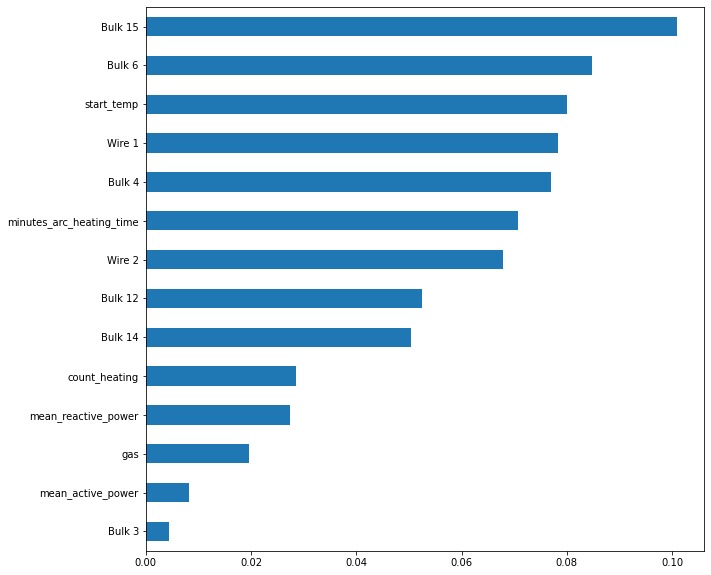

In [384]:
from sklearn.feature_selection import mutual_info_classif

importances = mutual_info_classif(features, target, random_state=RANDOM_STATE)

feature_importances = pd.Series(importances, features.columns[0:len(features.columns)])
feature_importances = feature_importances.sort_values()

plt.figure(figsize=(10,10))
feature_importances.plot(kind='barh')
plt.show()

### 3.3. Проверка CatBoostRegressor на тестовой выборке:

In [385]:
cat_boost_model.fit(features_train, target_train)
cb_test_pred = cat_boost_model.predict(features_test)

print(f"MAE CatBoostRegressor на тестовой выборке: {mean_absolute_error(target_test, cb_test_pred)}")

MAE CatBoostRegressor на тестовой выборке: 5.609467131978483


### Проверка на адекватность: обучу константную модель и сделаю предсказание.

In [386]:
constant_model = DummyRegressor(strategy="mean")

# `mean`, всегда предсказывает среднее значение тренировочного набора

In [387]:
constant_model.fit(features_train, target_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

Получу предсказание константной модели:

In [388]:
constant_pred = constant_model.predict(features_test)

In [389]:
print(f"MAE константной модели на тестовой выборке: {mean_absolute_error(target_test, constant_pred)}")

MAE константной модели на тестовой выборке: 7.5616814766702065


#### Вывод по поиску модели:

- Итоговое MAE `случайной модели` : 7.5616814766702065.

- Итоговое MAE, выбранной модели `CatBoostRegressor`: 5.609467131978483, что существенно ниже.

 Следует считать, что выбранная модель `справляется лучше` случайной.

## Вывод по проекту:

**1.** Была проведен **исследовательский анализ и предобработка данных** , в ходе которого было выявлено:

- Найдены отрицательная аномалия в реактивной мощности и пропуки в данных.

- Обнаружено, что требуется заменить название столбцов в соответсвии со стандартами PEP8 и тип хронения данных столбцов (дата в datetime).

- Найдены редкоиспользуемые сыпучие и проволочные материалы (те, что используются в менее 10% случаях). 


**2.** Проведена **предобработка данных**:

- Данные предобработаны, приведены к нужному формату и типу хранения.

- Созданы новые признаки, сформирован финальный датасет.

- В ходе проверки на мультиколлинеарность - выявлены высококоллинеарные признаки `minutes_arc_heating_time` и `count_heating` (коэффициент коллинеарности 0.8), один столбец был удален - `count_heating`.


**3.** В ходе **построения модели**:

- Данные были подготовлены к обучению.
- Выведена метрика качества MAE.
- Осуществлен выбор наиболее подходящей модели для оценки эффективной работы.
- Наилучшая модель (CatBoostRegressor) проверена на тестовой выборке.
- Модель прошла проверку на адекватность, сравнением со случайно предсказывающей моделью.
- Подготовлен прототип модели машинного обучения для металлургического предприятия, предсказывающий температуру стали.

# Отчёт по проекту

   Передо мной встала задача оптимизировать производственные расходы металлургического комбината ООО «Так закаляем сталь». Комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Мне предстояло построить модель, которая *предскажет температуру стали*.
   
   
   
   **1 этап.** Я внимательно изучила этапы обработки стали, выяснила, что сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат. Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки. Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов.
   
   
   
   
   **2 этап.** Затем я получила данные, состоящие из отдельных файлов, которые включали в себя:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры, содержащий в себе `целевой признак`;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

   Во всех файлах столбец `key` содержал номер партии. В файлах было несколько строк с одинаковым значением key: они соответствовали разным итерациям обработки.



 
   **3 этап.** Далее я принялась за **исследовательский анализ данных**: импортировав необходимые библиотеки и открыв сами файлы с данными, я выяснила, что во всех таблицах, на этапе предоработки,  мне потребуется переименовать названия столбцов в соответвии с общепринятыми стандартами PEP8, столбцы, содержащие дату привести к нужному типу (datetime). 
   
   - Исследовав таблицу `date_arc`, я обнаружила выброс - отрицательное значение реактивной мощности (в одной из итераций первого ключа), а также смогла визуализировать аномалию с помощью графика. Также, я выяснила, что чаще всего бывает 4-5 итераций нагрева для одной партии (ключа).
   
   - Исследуя данные о сыпучих материалах `data_bulk` и `data_bulk_time`, я выяснила, что обе таблицы содержат аналогичную структуру данных, описывают одни и те же объекты - сыпучие материалы (Bulk 1 - Bulk15), "пропуски" в данных означают, что какой-то сыпучий материал не использовался в процессе производства той или иной партии. Я решила узнать, есть ли редкоиспользуемые сыпучие материалы по средним не нулевым значениям, и обнаружила, что в *менее 10%* партий используются сыпучие материалы Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8. Я решила не использовать такие редкоиспользуемые материалы для построения модели.
   
   - Изучив данные о продувке сплава газом `data_gas`, аномалий я не обнаружила.
   
   - Самой ответсвенной частью анализа стало исследование таблицы измерения температуры `data_temp`, ведь там находился целевой признак - последний замер температуры в ключе. В данных было много пропусков (2901), на этапе предобработки было решено избавиться от них, а также удостовериться в том, что во всех итоговых ключах есть замер начальной температуры и последней, если где-то такие условия не учтены, то удалить такие данные. Посмотрев график распределения температуры, я заметила низкие значения температур (менее 1500 градусов), от них я тоже решила избавиться на этапе предобработки.
   
   - Проводя исследование данных о проволочных материалах `data_wire` и `data_wire_time`, обнаружила, что их структура хранения данных полностью аналогичны таблицам data_bulk и data_bulk_time. Поэтому, как и ранее, я обнаружила много редкоиспользуемых проволочных материалов. Из 9 проволочных материалов самые частоиспользуемые были Wire 1 Wire 2. От остальных было решено избавиться.
   
   
   
   
 **4 этап.** Затем, составив примерный план решения задачи, я приступила к этапу **предобработки данных**:
   
   - Столбцы всех таблиц переименовала (назвала английским языком, прописными буквами, без пробелов, "верблюжим" типом), данные привела к нужному типу (дата в datetime).

   - Из таблицы `data_arc` заменила отрицательную аномалию в реактивной мощности на адекватное значение (для замены выброса расситала коэффициент зависимоти - отношение active_power к reactive_power в каждом наблюдении в ключе, взяла среднюю полученных значений коэффициентов и множила на значение active_power, получила нужное значение reactive_power). 
   
   - Объединила таблицы  `data_bulk` и `data_bulk_time`. Удалила редкоиспольщуемые сыпучие материалы: Bulk 1, 11, 10, 5, 7, 2, 9, 13, 8. А также, написав функциию по предобработке дынных о материалах, я получила объединенную таблицу частоиспользуемых сыпучих материалов. Затем, такие же действия и функцию применила в отношении данных о проволочных материалах `data_wire` и `data_wire_time`, получив объединенную таблицу частоиспользуемых проволочных материалов, включив самые популярные - Wire 1 Wire 2. Из таблиц я удалила столбцы со временем, они мне не потребуются.
   
   - Из таблицы `data_temp` удалила ключи (key), у которых:

- Не было последнего замера температур, когда температуру замеряли до окончания последней итерации нагрева дугой. 
- Был только один замер температуры.
- Ключи, где температуры начала и конца нагрева были равны.

 Затем удалила низкие температуры (менее 1500 градусов).
   
   - Далее я объединила все таблицы в *одну итоговую по единым ключам*. 
   
   - Приступила к созданию *новых признаков и объединение данных в финальную таблицу*. Мною были созданны признаки: `средние значения активной и реактивной мощности` для каждого ключа, `длительность нагрева дугой`, `общую длительность нагрева дуги`, `количество нагревов` для каждого ключа, а также вынесла в итоговую таблицу столбцы о количестве каждого испольуемого материала в ключе, написав функцию, где использовала метод pd.get_dummies. Он выносит отдельный материал в отдельный столбец и присваивает 1 если матрериал присутствует в наблюдении (ключе) и 0, если нет. А далее я заменяла 1 на 'value', а после суммирую по ключу. Получаю красивую таблицу по всем материалам, которую тоже присоеденила к итоговой таблице.
   
   - Посмортрела коэффициенты корреляции итогового фрейма: обнаружила высококоллинеарные признаки `minutes_arc_heating_time` и `count_heating` (коэффициент коллинеарности 0.8). Так как это критично для линейных моделей, я удалила столбец `count_heating`.
   
   - Таким образом, данные были подготовлены для обучения. Целевым признаком стал столбец `end_temp`. 
   
   
   **5 этап.** Наконец, я приступила к этапу **обучения разных моделей и оценки их качества с помощью кросс-валидации, выбора лучшей модели и проверки её на тестовой выборке, а также проверки модели на адекватность**:
   
  - Разделила данные на `train` и `test` к соотношению 75:25. Выбрала количество кросс-валидаций равным 5.
  
  - В качестве метрики было выбрано MAE.
  
  - Инициализировала следующие модели: `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor`. Закрепила random_state=80822. Для линейной регрессии лучше масштабировать признаки, чтоб не делать отдельную выборку я прописала параметры в самой модели fit_intercept = True, normalize = True. Для CatBoostRegressor тоже определила loss_function='MAE', verbose=False.
  
  - Обучила модели на тренировочной выборке, проверила их качество с помощью кросс-валидации, лучшей моделью себя показал `CatBoostRegressor` с дефолтными параметрами, его MAE на train было 6.013933.
  
  - При проверке CatBoostRegressor на тестовой выборке, MAE было 5.609467131978483.
  
  - Было интересно посмотреть график важности фичей, выяснились маловажные - mean_active_power, Bulk 3, но я все равно решила оставить их и испольовать.
  
  - Также, я не забыла провести проверку на адекватность: обучила константную модель (`DummyRegressor`(strategy="mean")) и сделала предсказание, получила MAE на тесте = 7.5616814766702065. Следует следует считать, что выбранная модель `справляется лучше` случайной.
  
  Таким образом, я подготовила прототип модели машинного обучения для заказчика, предсказывающий температуру стали.
  
  
  Сравнивая исходный план с фактическим, могу сказать, что удалось реализовать всё задуманное. Все пункты плана были выполнены. Радует, что лучшая модель отлично справилась даже с дефолными гиперпараметрами. Особых сложностей в выполнении проекта не было, даже когда создавала новые признаки для модели, они отлично помогли улучшить ее качество.
  
  Ключевые этапы проекта были: изучение задачи, знакомство с данными, исследовательский анализ данных, предобработка данных, обучение разных моделей и оценка их качества с помощью кросс-валидации, выбор лучшей модели и проверка её на тестовой выборке, а также проверка модели на адекватность.